### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive2')

Mounted at /gdrive2


In [ ]:
%cd /gdrive2/My Drive/ANN/CH2/Tests

/gdrive2/My Drive/ANN/CH2/Tests


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


# Initial Setup

In [ ]:
# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


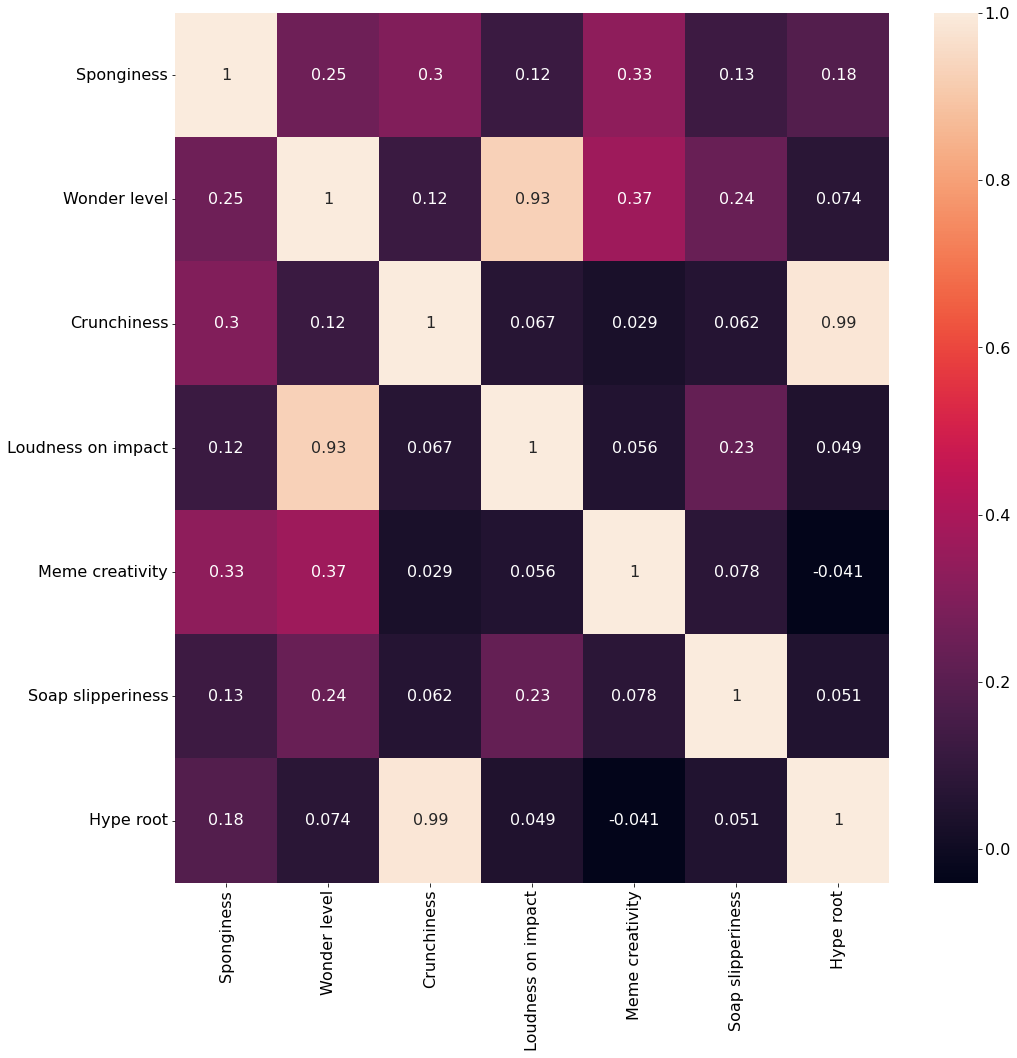

In [ ]:
corrMatrix = dataset.corr()
plt.figure(figsize = (16,16))
sns.heatmap(corrMatrix, annot=True)
plt.show()

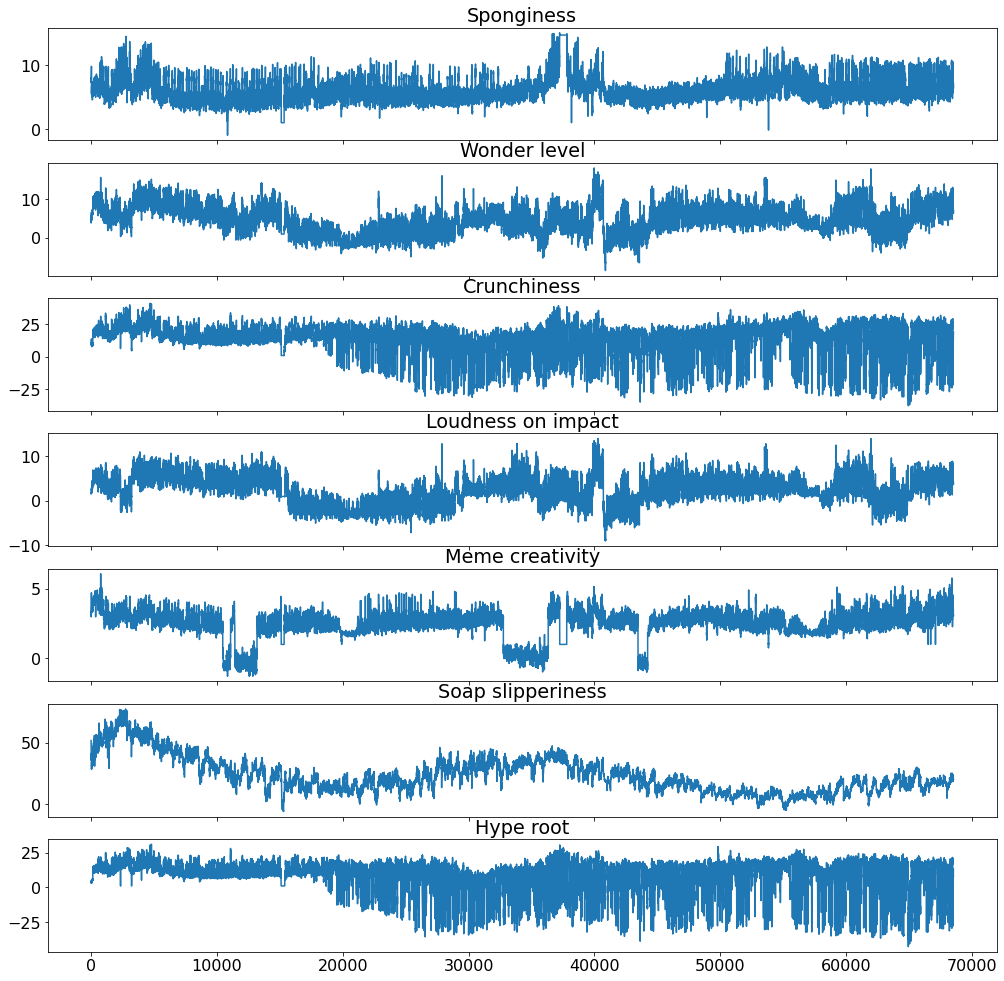

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(67528, 7) (1000, 7)


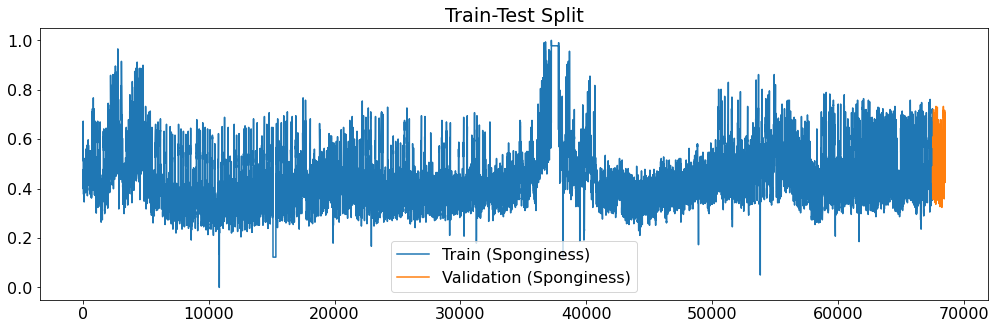

In [ ]:
# Normalize both features and labels
X_min = dataset.min()
X_max = dataset.max()

validation_size = 1000
X_train_raw = dataset.iloc[:-validation_size]
X_validation_raw = dataset.iloc[-validation_size:]
print(X_train_raw.shape, X_validation_raw.shape)

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_validation_raw = (X_validation_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_validation_raw.Sponginess, label='Validation (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

# V 1.0

### SciNet - W 720 - S 1 - T 16 #6

In [ ]:
window = 720
stride = 1

In [ ]:
from typing import Tuple
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2


class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: float, kernel_size: int, neg_slope: float = .01, dropout: float = .5, **kwargs):
        if filters <= 0 or h <= 0:
            raise ValueError('filters and h must be positive')
        super(InnerConv1DBlock, self).__init__(**kwargs)
        self.conv1d = tf.keras.layers.Conv1D(max(round(h * filters), 1), kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor, training=None):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        if training:
            x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class SciBlock(tf.keras.layers.Layer):
    def __init__(self, features: int, kernel_size: int, h: int, **kwargs):
        """
        :param features: number of features in the output
        :param kernel_size: kernel size of the convolutional layers
        :param h: scaling factor for convolutional module
        """

        super(SciBlock, self).__init__(**kwargs)
        self.features = features
        self.kernel_size = kernel_size
        self.h = h

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'features': self.features,
            'kernel_size': self.kernel_size,
            'h': self.h,
        })
        return config

    def build(self, input_shape):
        self.conv1ds = {k: InnerConv1DBlock(filters=self.features, h=self.h, kernel_size=self.kernel_size, name=k)
                        for k in ['psi', 'phi', 'eta', 'rho']}  # regularize?
        super().build(input_shape)
        # [layer.build(input_shape) for layer in self.conv1ds.values()]  # unneeded?

    def call(self, inputs, training=None):
        F_odd, F_even = inputs[:, ::2], inputs[:, 1::2]

        # Interactive learning as described in the paper
        F_s_odd = F_odd * tf.math.exp(self.conv1ds['phi'](F_even))
        F_s_even = F_even * tf.math.exp(self.conv1ds['psi'](F_odd))

        F_prime_odd = F_s_odd + self.conv1ds['rho'](F_s_even)
        F_prime_even = F_s_even - self.conv1ds['eta'](F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    """A layer used to reverse the even-odd split operation."""

    def __init__(self, **kwargs):
        super(Interleave, self).__init__(**kwargs)

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2
        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1] * 2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, horizon: int, features: int, levels: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), **kwargs):
        """
        :param horizon: number of time stamps in output
        :param features: number of features in output
        :param levels: height of the binary tree + 1
        :param h: scaling factor for convolutional module in each SciBlock
        :param kernel_size: kernel size of convolutional module in each SciBlock
        :param regularizer: activity regularization (not implemented)
        """

        if levels < 1:
            raise ValueError('Must have at least 1 level')
        super(SciNet, self).__init__(**kwargs)
        self.horizon = horizon
        self.features = features
        self.levels = levels
        self.interleave = Interleave()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(
            horizon * features,
            kernel_regularizer=L1L2(0.001, 0.01),
            # activity_regularizer=L1L2(0.001, 0.01)
        )
        # self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

        # tree of sciblocks
        self.sciblocks = [SciBlock(features=features, kernel_size=kernel_size, h=h)
                          for _ in range(2 ** levels - 1)]

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'horizon': self.horizon,
            'features': self.features,
            'levels': self.levels,
            'interleave': self.interleave,
            'flatten': self.flatten,
            'dense': self.dense,
            'sciblocks': self.sciblocks,
        })
        return config

    def build(self, input_shape):
        if input_shape[1] / 2 ** self.levels % 1 != 0:
            raise ValueError(f'timestamps {input_shape[1]} must be evenly divisible by a tree with '
                             f'{self.levels} levels')
        super().build(input_shape)
        # [layer.build(input_shape) for layer in self.sciblocks]  # input_shape

    def call(self, inputs, training=None):
        # cascade input down a binary tree of sci-blocks
        lvl_inputs = [inputs]  # inputs for current level of the tree
        for i in range(self.levels):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            lvl_outputs = [output for j, tensor in zip(range(i_start, i_end), lvl_inputs)
                           for output in self.sciblocks[j](tensor)]
            lvl_inputs = lvl_outputs

        x = self.interleave(lvl_outputs)
        x += inputs

        # not sure if this is the correct way of doing it. The paper merely said to use a fully connected layer to
        # produce an output. Can't use TimeDistributed wrapper. It would force the layer's timestamps to match that of
        # the input -- something SCINet is supposed to solve
        x = self.flatten(x)
        x = self.dense(x)
        x = tf.reshape(x, (-1, self.horizon, self.features))

        return x


class StackedSciNet(tf.keras.layers.Layer):
    def __init__(self, horizon: int, features: int, stacks: int, levels: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), **kwargs):
        """
        :param horizon: number of time stamps in output
        :param stacks: number of stacked SciNets
        :param levels: number of levels for each SciNet
        :param h: scaling factor for convolutional module in each SciBlock
        :param kernel_size: kernel size of convolutional module in each SciBlock
        :param regularizer: activity regularization (not implemented)
        """

        if stacks < 1:
            raise ValueError('Must have at least 1 stack')
        super(StackedSciNet, self).__init__(**kwargs)
        self.horizon = horizon
        self.features = features
        self.stacks = stacks
        self.levels = levels
        self.h = h
        self.kernel_size = kernel_size
        self.regularizer = regularizer
        self.scinets = [SciNet(horizon=horizon, features=features, levels=levels, h=h, kernel_size=kernel_size,
                               regularizer=regularizer) for _ in range(stacks)]
        self.mse_fn = tf.keras.metrics.MeanSquaredError()
        self.mae_fn = tf.keras.metrics.MeanAbsoluteError()

    # def build(self, input_shape):
    #     super().build(input_shape)
    #     [stack.build(input_shape) for stack in self.scinets]

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'horizon': self.horizon,
            'features': self.features,
            'stacks': self.stacks,
            'levels': self.levels,
            'h': self.h,
            'kernel_size': self.kernel_size,
            'regularizer': self.regularizer,
        })
        return config

    def call(self, inputs, targets=None, sample_weights=None, training=None):
        outputs = []
        for scinet in self.scinets:
            x = scinet(inputs)
            outputs.append(x)  # keep each stack's output for intermediate supervision
            inputs = tf.concat([x, inputs[:, x.shape[1]:, :]], axis=1)

        if targets is not None:
            # Calculate metrics
            mse = self.mse_fn(targets, x, sample_weights)
            mae = self.mae_fn(targets, x, sample_weights)
            self.add_metric(mse, name='mean_squared_error')
            self.add_metric(mae, name='mean_absolute_error')

            if training:
                # Calculate loss as sum of mean of norms of differences between output and input feature vectors for
                # each stack
                stacked_outputs = tf.stack(outputs)
                differences = stacked_outputs - targets
                loss = tf.linalg.normalize(differences, axis=1)[1]
                loss = tf.reshape(loss, (-1, self.horizon))
                loss = tf.reduce_sum(loss, 1)
                loss = loss / self.horizon
                loss = tf.reduce_sum(loss)
                self.add_loss(loss)

        return x

In [ ]:
target_labels = dataset.columns
telescope = 16

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)

X_validation, y_validation = build_sequences(X_validation_raw, target_labels, window, stride, telescope)

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((67664, 720, 7), (67664, 16, 7), (704, 720, 7), (704, 16, 7))

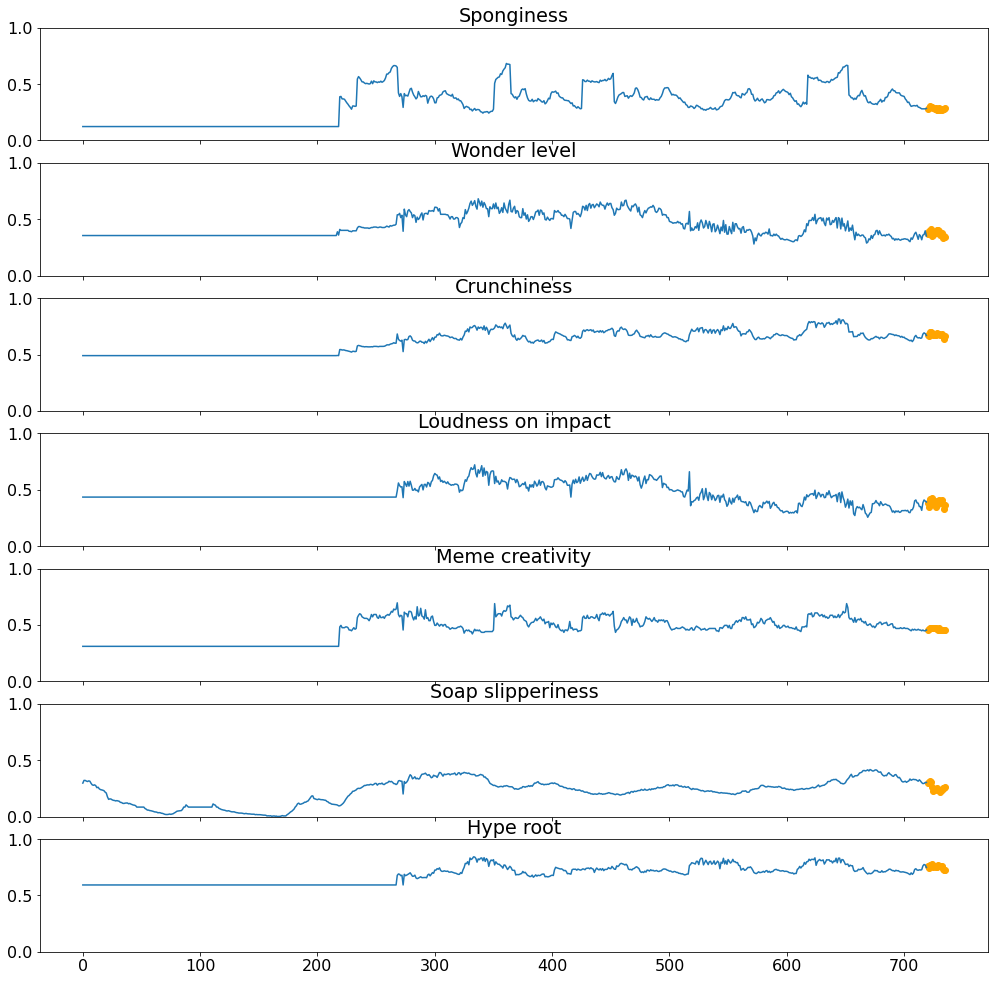

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512
epochs = 200

In [ ]:
def make_model(input_shape, output_shape):
    inputs = tf.keras.Input(shape=(window, 7), name='inputs')
    # x = SciNet(horizon, levels=L, h=h, kernel_size=kernel_size)(inputs)
    # model = tf.keras.Model(inputs, x)
    targets = tf.keras.Input(shape=(telescope, 7), name='targets')
    predictions = StackedSciNet(horizon=telescope, features=input_shape[-1], stacks=1, levels=4, h=4,
                                kernel_size=5,
                                regularizer=(1e-3, 0.1))(inputs, targets)
    model = tf.keras.Model(inputs=[inputs, targets], outputs=predictions)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 720, 7)]     0           []                               
                                                                                                  
 targets (InputLayer)           [(None, 16, 7)]      0           []                               
                                                                                                  
 stacked_sci_net (StackedSciNet  (None, 16, 7)       684292      ['inputs[0][0]',                 
 )                                                                'targets[0][0]']                
                                                                                                  
Total params: 684,292
Trainable params: 684,292
Non-trainable params: 0
______________________

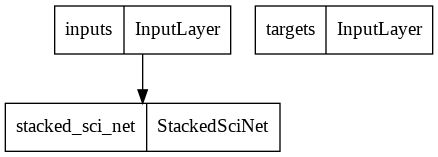

In [ ]:
model = make_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = {'inputs': X_train, 'targets': y_train},
    y = y_train,
    validation_data={'inputs': X_validation, 'targets': y_validation},
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200
133/133 [==============================] - 20s 152ms/step - loss: 8.3082 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0341 - val_loss: 0.7005 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0469 - lr: 0.0010
Epoch 2/200
133/133 [==============================] - 14s 104ms/step - loss: 8.2686 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0341 - val_loss: 0.6674 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0508 - lr: 0.0010
Epoch 3/200
133/133 [==============================] - 14s 104ms/step - loss: 8.2270 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0340 - val_loss: 0.6395 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0468 - lr: 0.0010
Epoch 4/200
133/133 [==============================] - 14s 104ms/step - loss: 8.1943 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0340 - val_loss: 0.6273 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0486 - lr: 0.0010
Epoch 5/200
133/133 [=======

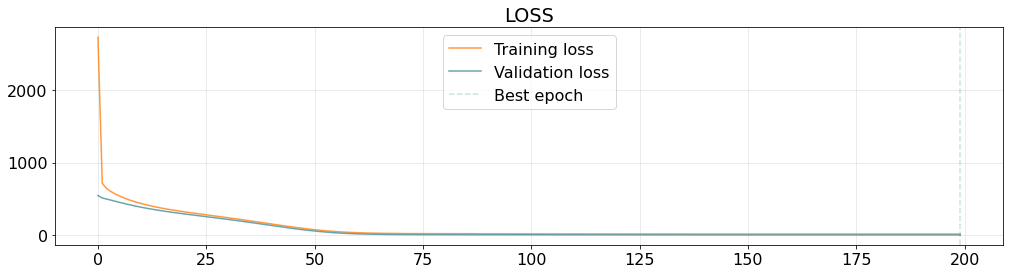

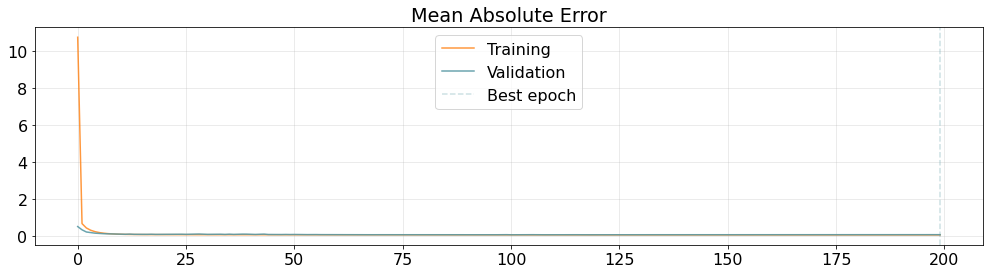

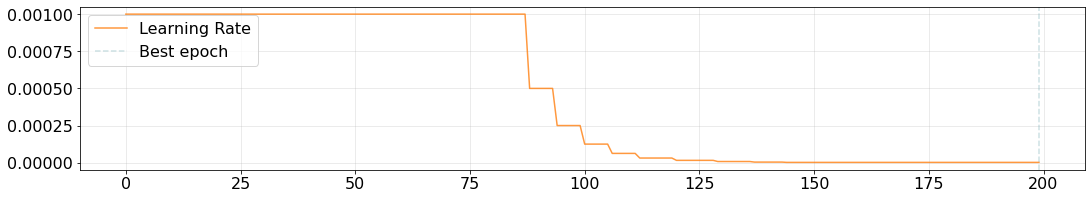

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('LOSS')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mean_absolute_error'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mean_absolute_error'], label='Validation', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
 model.save('SciNetTest_full.h5')
# model = tfk.models.load_model('AuroregressiveForecasting')

In [ ]:
X_validation = X_train_raw[-window:]
y_validation = X_validation_raw

In [ ]:
reg_telescope = 800
X_validation_reg =  np.expand_dims(X_validation, axis=0)
y_validation_reg =  np.expand_dims(y_validation, axis=0)

In [ ]:
reg_predictions = np.array([])
X_temp = X_validation_reg
placeholder = np.empty([telescope, 7])
placeholder = np.expand_dims(placeholder, axis=0)
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict({'inputs': X_temp, 'targets': placeholder})
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(1, 800, 7)

In [ ]:
y_validation_reg.shape

(1, 800, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_validation_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_validation_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0067782374>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06305525>)

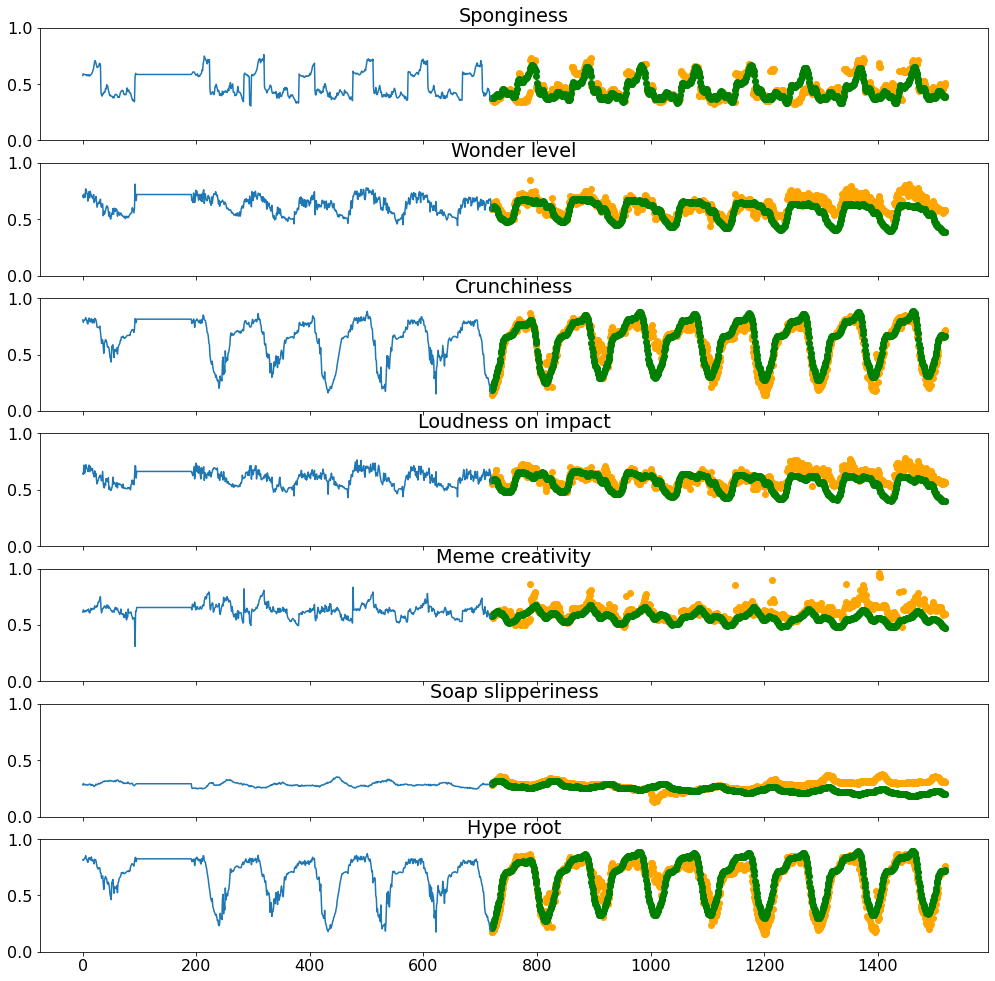

In [ ]:
inspect_multivariate_prediction(X_validation_reg, y_validation_reg, reg_predictions, target_labels, reg_telescope)

# V 3.6

### SciNet - W 720 - S 1 - T 16 downsample and interpolate

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
window = 720
stride = 1

SciNet Implementation is an adaptation of open repository: https://github.com/Meatssauce/SCINet

In [ ]:
from typing import Tuple
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2


class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: float, kernel_size: int, neg_slope: float = .01, dropout: float = .5, **kwargs):
        if filters <= 0 or h <= 0:
            raise ValueError('filters and h must be positive')
        super(InnerConv1DBlock, self).__init__(**kwargs)
        self.conv1d = tf.keras.layers.Conv1D(max(round(h * filters), 1), kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor, training=None):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        if training:
            x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class SciBlock(tf.keras.layers.Layer):
    def __init__(self, features: int, kernel_size: int, h: int, **kwargs):
        """
        :param features: number of features in the output
        :param kernel_size: kernel size of the convolutional layers
        :param h: scaling factor for convolutional module
        """

        super(SciBlock, self).__init__(**kwargs)
        self.features = features
        self.kernel_size = kernel_size
        self.h = h

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'features': self.features,
            'kernel_size': self.kernel_size,
            'h': self.h,
        })
        return config

    def build(self, input_shape):
        self.conv1ds = {k: InnerConv1DBlock(filters=self.features, h=self.h, kernel_size=self.kernel_size, name=k)
                        for k in ['psi', 'phi', 'eta', 'rho']}  # regularize?
        super().build(input_shape)
        # [layer.build(input_shape) for layer in self.conv1ds.values()]  # unneeded?

    def call(self, inputs, training=None):
        F_odd, F_even = inputs[:, ::2], inputs[:, 1::2]

        # Interactive learning as described in the paper
        F_s_odd = F_odd * tf.math.exp(self.conv1ds['phi'](F_even))
        F_s_even = F_even * tf.math.exp(self.conv1ds['psi'](F_odd))

        F_prime_odd = F_s_odd + self.conv1ds['rho'](F_s_even)
        F_prime_even = F_s_even - self.conv1ds['eta'](F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    """A layer used to reverse the even-odd split operation."""

    def __init__(self, **kwargs):
        super(Interleave, self).__init__(**kwargs)

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2
        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1] * 2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, horizon: int, features: int, levels: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), **kwargs):
        """
        :param horizon: number of time stamps in output
        :param features: number of features in output
        :param levels: height of the binary tree + 1
        :param h: scaling factor for convolutional module in each SciBlock
        :param kernel_size: kernel size of convolutional module in each SciBlock
        :param regularizer: activity regularization (not implemented)
        """

        if levels < 1:
            raise ValueError('Must have at least 1 level')
        super(SciNet, self).__init__(**kwargs)
        self.horizon = horizon
        self.features = features
        self.levels = levels
        self.interleave = Interleave()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(
            horizon * features,
            kernel_regularizer=L1L2(0.001, 0.01),
            # activity_regularizer=L1L2(0.001, 0.01)
        )
        # self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

        # tree of sciblocks
        self.sciblocks = [SciBlock(features=features, kernel_size=kernel_size, h=h)
                          for _ in range(2 ** levels - 1)]

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'horizon': self.horizon,
            'features': self.features,
            'levels': self.levels,
            'interleave': self.interleave,
            'flatten': self.flatten,
            'dense': self.dense,
            'sciblocks': self.sciblocks,
        })
        return config

    def build(self, input_shape):
        if input_shape[1] / 2 ** self.levels % 1 != 0:
            raise ValueError(f'timestamps {input_shape[1]} must be evenly divisible by a tree with '
                             f'{self.levels} levels')
        super().build(input_shape)
        # [layer.build(input_shape) for layer in self.sciblocks]  # input_shape

    def call(self, inputs, training=None):
        # cascade input down a binary tree of sci-blocks
        lvl_inputs = [inputs]  # inputs for current level of the tree
        for i in range(self.levels):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            lvl_outputs = [output for j, tensor in zip(range(i_start, i_end), lvl_inputs)
                           for output in self.sciblocks[j](tensor)]
            lvl_inputs = lvl_outputs

        x = self.interleave(lvl_outputs)
        x += inputs

        # not sure if this is the correct way of doing it. The paper merely said to use a fully connected layer to
        # produce an output. Can't use TimeDistributed wrapper. It would force the layer's timestamps to match that of
        # the input -- something SCINet is supposed to solve
        x = self.flatten(x)
        x = self.dense(x)
        x = tf.reshape(x, (-1, self.horizon, self.features))

        return x


class StackedSciNet(tf.keras.layers.Layer):
    def __init__(self, horizon: int, features: int, stacks: int, levels: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), **kwargs):
        """
        :param horizon: number of time stamps in output
        :param stacks: number of stacked SciNets
        :param levels: number of levels for each SciNet
        :param h: scaling factor for convolutional module in each SciBlock
        :param kernel_size: kernel size of convolutional module in each SciBlock
        :param regularizer: activity regularization (not implemented)
        """

        if stacks < 1:
            raise ValueError('Must have at least 1 stack')
        super(StackedSciNet, self).__init__(**kwargs)
        self.horizon = horizon
        self.features = features
        self.stacks = stacks
        self.levels = levels
        self.h = h
        self.kernel_size = kernel_size
        self.regularizer = regularizer
        self.scinets = [SciNet(horizon=horizon, features=features, levels=levels, h=h, kernel_size=kernel_size,
                               regularizer=regularizer) for _ in range(stacks)]
        self.mse_fn = tf.keras.metrics.MeanSquaredError()
        self.mae_fn = tf.keras.metrics.MeanAbsoluteError()

    # def build(self, input_shape):
    #     super().build(input_shape)
    #     [stack.build(input_shape) for stack in self.scinets]

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'horizon': self.horizon,
            'features': self.features,
            'stacks': self.stacks,
            'levels': self.levels,
            'h': self.h,
            'kernel_size': self.kernel_size,
            'regularizer': self.regularizer,
        })
        return config

    def call(self, inputs, targets=None, sample_weights=None, training=None):
        outputs = []
        for scinet in self.scinets:
            x = scinet(inputs)
            outputs.append(x)  # keep each stack's output for intermediate supervision
            inputs = tf.concat([x, inputs[:, x.shape[1]:, :]], axis=1)

        if targets is not None:
            # Calculate metrics
            mse = self.mse_fn(targets, x, sample_weights)
            mae = self.mae_fn(targets, x, sample_weights)
            self.add_metric(mse, name='mean_squared_error')
            self.add_metric(mae, name='mean_absolute_error')

            if training:
                # Calculate loss as sum of mean of norms of differences between output and input feature vectors for
                # each stack
                stacked_outputs = tf.stack(outputs)
                differences = stacked_outputs - targets
                loss = tf.linalg.normalize(differences, axis=1)[1]
                loss = tf.reshape(loss, (-1, self.horizon))
                loss = tf.reduce_sum(loss, 1)
                loss = loss / self.horizon
                loss = tf.reduce_sum(loss)
                self.add_loss(loss)

        return x

In [ ]:
target_labels = dataset.columns
telescope = 16

In [ ]:
X_train1, y_train1 = build_sequences(X_train_raw[::2], target_labels, window, stride, telescope)
X_train2, y_train2 = build_sequences(X_train_raw[1::2], target_labels, window, stride, telescope)

X_train = np.concatenate((X_train1, X_train2), axis=0)
y_train = np.concatenate((y_train1, y_train2), axis=0)

X_validation_raw_new = pd.concat((X_train_raw[-window:], X_validation_raw), axis=0)

X_validation1, y_validation1 = build_sequences(X_validation_raw_new[::2], target_labels, window, stride, telescope)
X_validation2, y_validation2 = build_sequences(X_validation_raw_new[1::2], target_labels, window, stride, telescope)

X_validation = np.concatenate((X_validation1, X_validation2), axis=0)
y_validation = np.concatenate((y_validation1, y_validation2), axis=0)

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((66208, 720, 7), (66208, 16, 7), (1408, 720, 7), (1408, 16, 7))

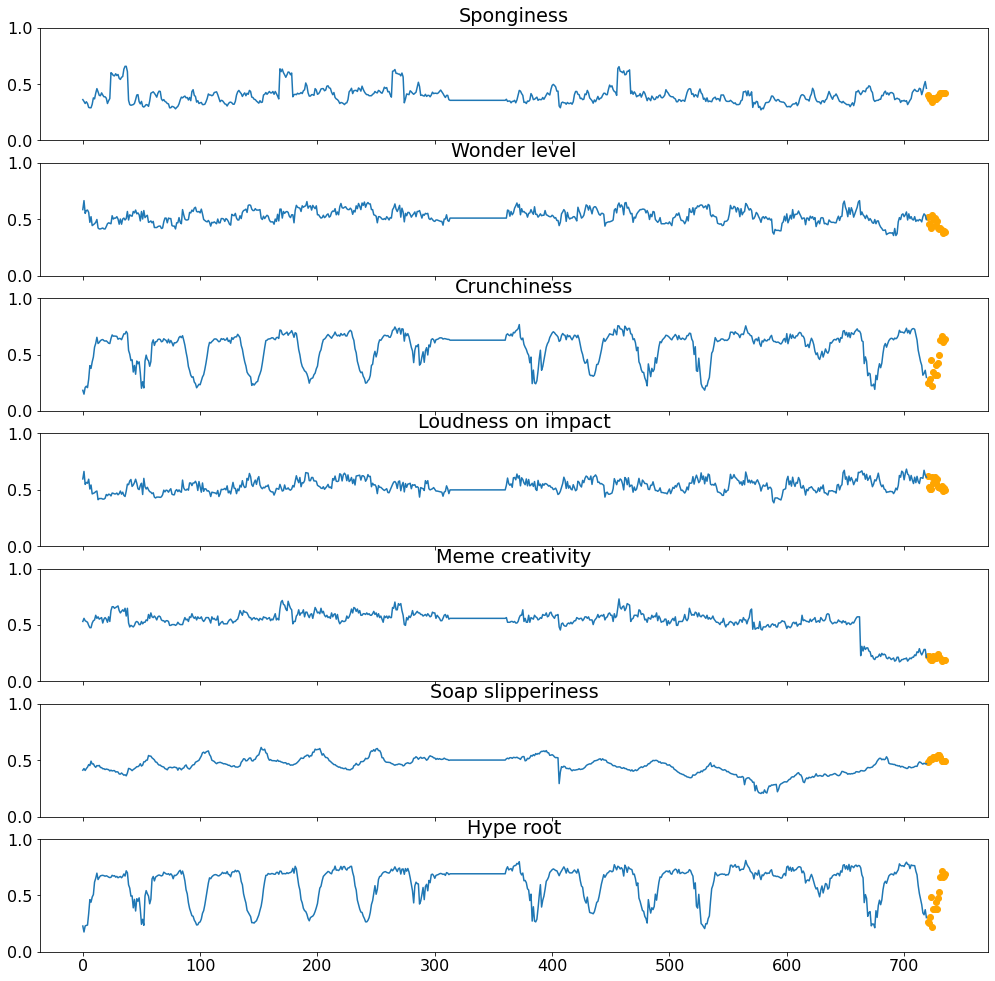

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512
epochs = 300

In [ ]:
def make_model(input_shape, output_shape):
    inputs = tf.keras.Input(shape=(window, 7), name='inputs')
    # x = SciNet(horizon, levels=L, h=h, kernel_size=kernel_size)(inputs)
    # model = tf.keras.Model(inputs, x)
    targets = tf.keras.Input(shape=(telescope, 7), name='targets')
    predictions = StackedSciNet(horizon=telescope, features=input_shape[-1], stacks=1, levels=4, h=4,
                                kernel_size=5,
                                regularizer=(1e-3, 0.1))(inputs, targets)
    model = tf.keras.Model(inputs=[inputs, targets], outputs=predictions)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 720, 7)]     0           []                               
                                                                                                  
 targets (InputLayer)           [(None, 16, 7)]      0           []                               
                                                                                                  
 stacked_sci_net (StackedSciNet  (None, 16, 7)       684292      ['inputs[0][0]',                 
 )                                                                'targets[0][0]']                
                                                                                                  
Total params: 684,292
Trainable params: 684,292
Non-trainable params: 0
______________________

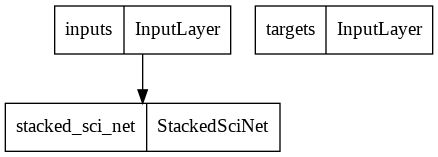

In [ ]:
with strategy.scope():
  model = make_model(input_shape, output_shape)
  
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = {'inputs': X_train, 'targets': y_train},
    y = y_train,
    validation_data={'inputs': X_validation, 'targets': y_validation},
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_absolute_error', mode='min', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/300
130/130 [==============================] - 85s 262ms/step - loss: 32.6777 - mean_squared_error: 0.5720 - mean_absolute_error: 0.3113 - val_loss: 9.9609 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1431 - lr: 0.0010
Epoch 2/300
130/130 [==============================] - 7s 55ms/step - loss: 16.3532 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1025 - val_loss: 8.7518 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1363 - lr: 0.0010
Epoch 3/300
130/130 [==============================] - 7s 56ms/step - loss: 13.9758 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0834 - val_loss: 7.6203 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1147 - lr: 0.0010
Epoch 4/300
130/130 [==============================] - 8s 60ms/step - loss: 12.1116 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0716 - val_loss: 6.5290 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1103 - lr: 0.0010
Epoch 5/300
130/130 [=========

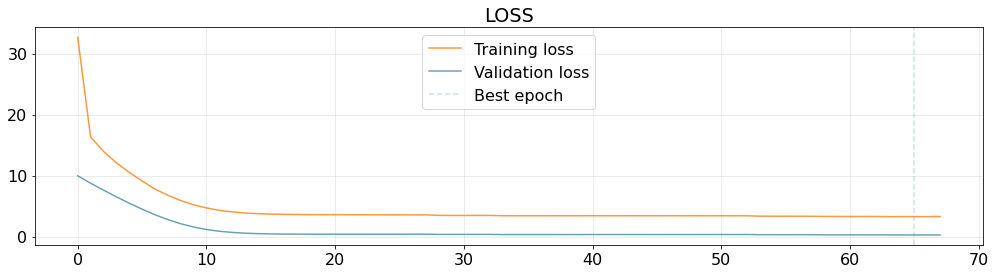

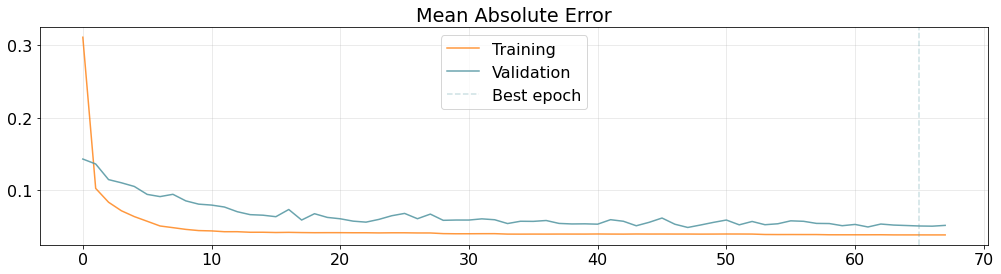

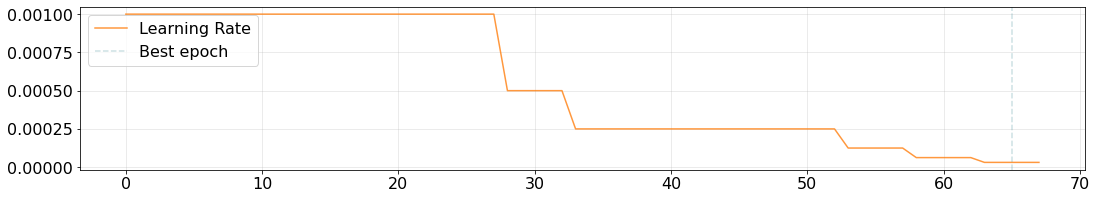

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('LOSS')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mean_absolute_error'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mean_absolute_error'], label='Validation', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
 model.save('SciNetTest_downsampled_3.h5')
# model = tfk.models.load_model('AuroregressiveForecasting')

In [ ]:
X_validation = X_train_raw[-window*2::2]
y_validation = X_validation_raw

In [ ]:
reg_telescope = 500
X_validation_reg =  np.expand_dims(X_validation, axis=0)
y_validation_reg =  np.expand_dims(y_validation, axis=0)

In [ ]:
reg_predictions = np.array([])
X_temp = X_validation_reg
placeholder = np.empty([telescope, 7])
placeholder = np.expand_dims(placeholder, axis=0)
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict({'inputs': X_temp, 'targets': placeholder})
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

(1, 512, 7)

In [ ]:
reg_predictions = reg_predictions[0]

In [ ]:
old_pred = pd.DataFrame(reg_predictions)
upsampled_pred = pd.DataFrame()

In [ ]:
from scipy import interpolate

for column in old_pred.columns:
  y = old_pred[column].to_numpy()
  x = np.arange(0, len(y))
  f = interpolate.interp1d(x, y)

  x_new = np.arange(0, len(y)-1, 0.5)
  ynew = f(x_new)
  upsampled_pred[column] = ynew

In [ ]:
upsampled_pred.shape

(1022, 7)

In [ ]:
upsampled_pred = upsampled_pred[:1000]

In [ ]:
upsampled_pred =  np.expand_dims(upsampled_pred, axis=0)

In [ ]:
y_validation_reg.shape

(1, 1000, 7)

In [ ]:
upsampled_pred.shape

(1, 1000, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_validation_reg.flatten(),upsampled_pred.flatten())
mean_absolute_error = tfk.metrics.mae(y_validation_reg.flatten(),upsampled_pred.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=0.0051167670243732425>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.05115761656673666>)

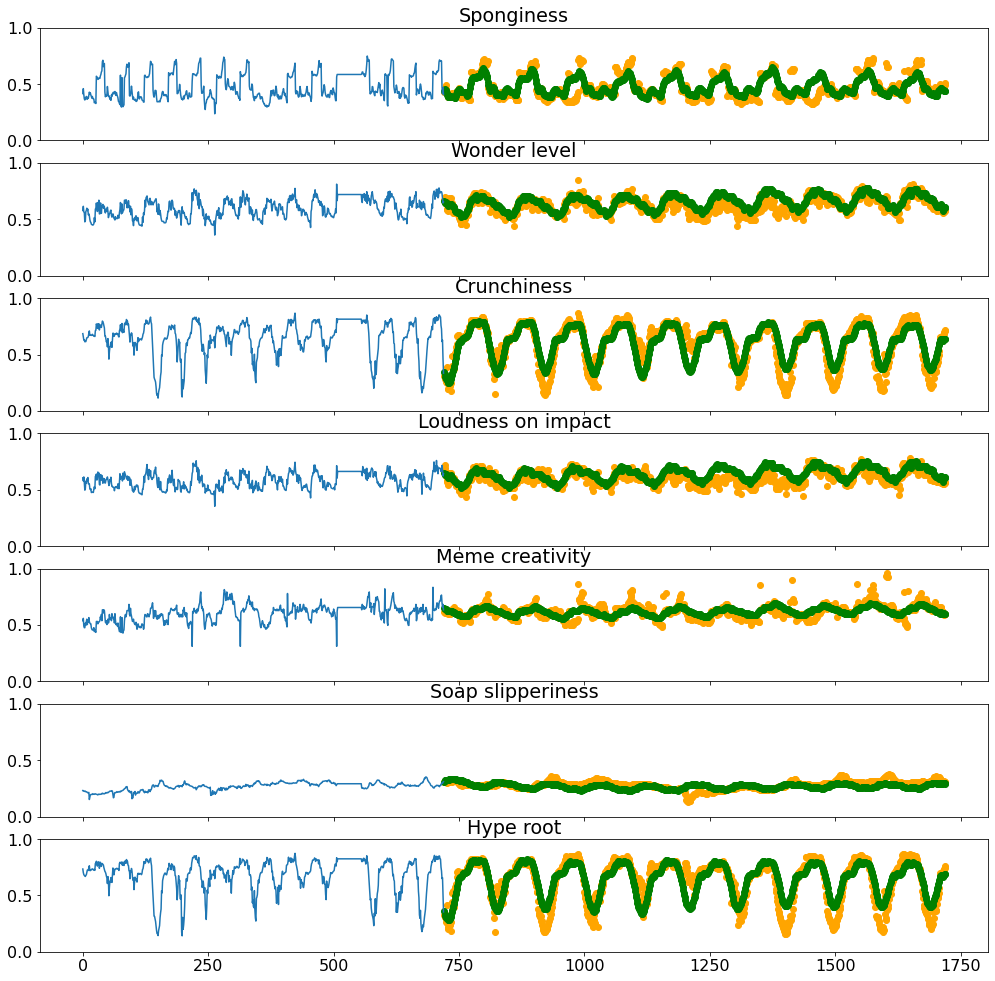

In [ ]:
inspect_multivariate_prediction(X_validation_reg, y_validation_reg, upsampled_pred, target_labels, 1000)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_validation_reg.flatten(),upsampled_pred.flatten())
mean_absolute_error = tfk.metrics.mae(y_validation_reg.flatten(),upsampled_pred.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=0.007744403169819177>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.06373645164042355>)

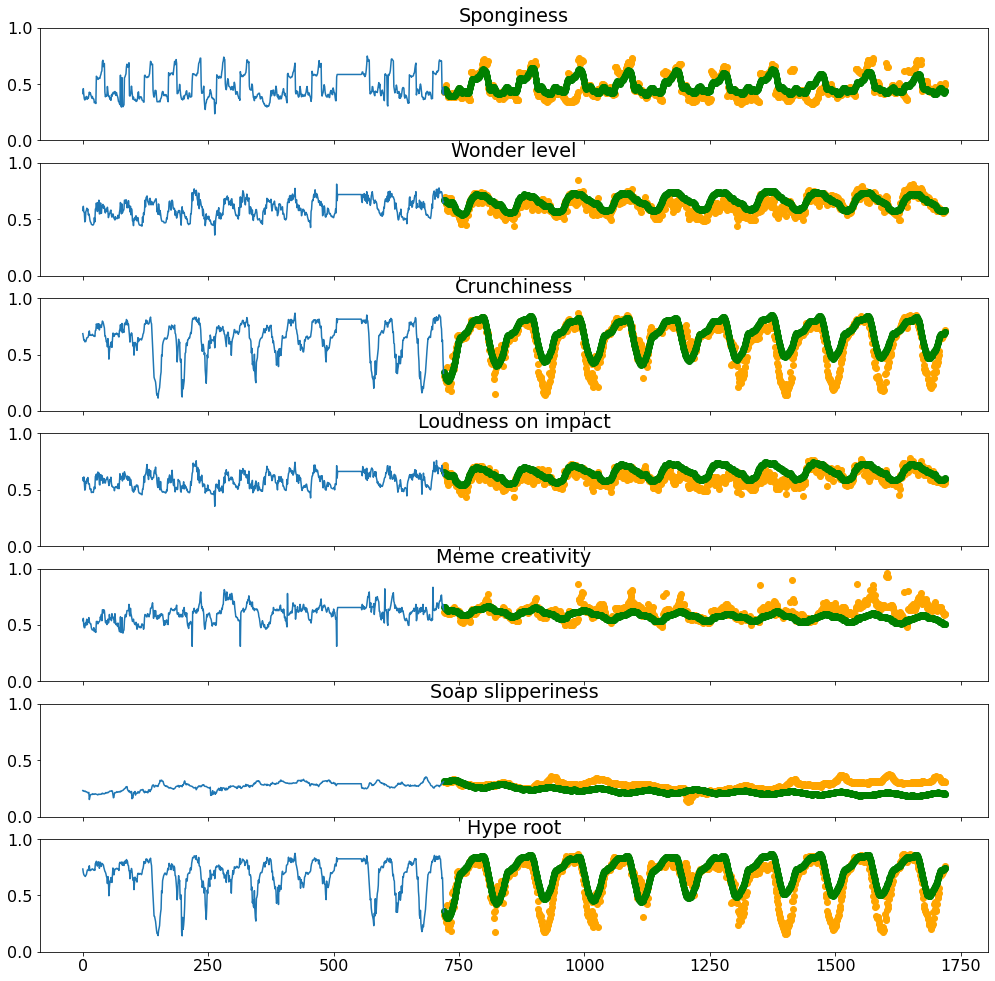

In [ ]:
inspect_multivariate_prediction(X_validation_reg, y_validation_reg, upsampled_pred, target_labels, 1000)